## changelog
1. changed base model from roberta to twitter-roberta-base-sentiment-latest, which is a fine-tuned version of roberta specific for sentiment analysis task
2. to fix overfitting, tried:
- Add weight_decay in the optimizer, This helps regularize large weights and improve generalization.
-

In [ ]:
!pip install transformers torch numpy pandas matplotlib focal-loss

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
## load csv file from cloud drive
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/"  # this is your drive

Mounted at /content/drive/


In [3]:
from transformers import get_scheduler

In [4]:
data_standard = pd.read_csv(data_path + 'data_standard.csv')
#data_nostandard = pd.read_csv('data_nostandard_v2.csv')

# Select text and target variables
texts = data_standard['text'].tolist()
labels = data_standard['sentiment'].tolist()

# Divide the training set and testing set
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [5]:
# Load RoBERTa tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
#decive setup for MPS
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback if MPS is not available
print(f"Using device: {device}")

#move your model and data to the MPS device
model = model.to(device)


Using device: cpu


In [7]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=34,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Create dataset
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:

# Define hyperparameters
num_epochs = 8
learning_rate = 2e-5

# Define optimizer and loss function
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
# use different learning rate for different layers
# Separate parameter groups for different layers with different learning rates
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)


criterion = nn.CrossEntropyLoss()

In [10]:

# Learning rate scheduler
num_training_steps = num_epochs * len(train_loader)
#lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [11]:
from torch.optim.lr_scheduler import StepLR

In [12]:
# Use StepLR to reduce learning rate every 3 epochs by a factor of 0.5
#scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

In [12]:
def freeze_layers(model, num_layers_to_unfreeze):
    for param in model.roberta.parameters():
        param.requires_grad = False  # Freeze everything
    if num_layers_to_unfreeze > 0:
        for layer in model.roberta.encoder.layer[-num_layers_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True  # Unfreeze selected layers

In [13]:
# Training function with layer-wise unfreezing
def train_model(model, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    num_unfrozen_layers = 0
    freeze_layers(model, num_unfrozen_layers)
    total_layers = len(model.roberta.encoder.layer)

    for epoch in range(num_epochs):
        # Gradually unfreeze more layers
        if epoch % unfreeze_after == 0 and num_unfrozen_layers < total_layers:
            num_unfrozen_layers = min(num_unfrozen_layers + unfreeze_step, total_layers)
            freeze_layers(model, num_unfrozen_layers)
            print(f"🔓 Unfreezing {num_unfrozen_layers}/{total_layers} layers")

        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            #lr_scheduler.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        test_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                test_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
        print(f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies


In [23]:
# train with orginal method
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, optimizer, criterion, num_epochs, unfreeze_after=2, unfreeze_step=4)

🔓 Unfreezing 4/12 layers
Epoch: 1/8, Train Loss: 0.0151, Train Acc: 0.9950
Test Loss: 1.0110, Test Acc: 0.7800
Epoch: 2/8, Train Loss: 0.0028, Train Acc: 1.0000
Test Loss: 0.9208, Test Acc: 0.8200
🔓 Unfreezing 8/12 layers
Epoch: 3/8, Train Loss: 0.0008, Train Acc: 1.0000
Test Loss: 0.8915, Test Acc: 0.8400
Epoch: 4/8, Train Loss: 0.0005, Train Acc: 1.0000
Test Loss: 0.8177, Test Acc: 0.8500
🔓 Unfreezing 12/12 layers
Epoch: 5/8, Train Loss: 0.0003, Train Acc: 1.0000
Test Loss: 0.7837, Test Acc: 0.8900
Epoch: 6/8, Train Loss: 0.0002, Train Acc: 1.0000
Test Loss: 0.7902, Test Acc: 0.8700
Epoch: 7/8, Train Loss: 0.0003, Train Acc: 1.0000
Test Loss: 0.8129, Test Acc: 0.8900
Epoch: 8/8, Train Loss: 0.0008, Train Acc: 1.0000
Test Loss: 0.9079, Test Acc: 0.8500



Training with learning rate: 0.1


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔓 Unfreezing 4/12 layers
Epoch: 1/8, Train Loss: 23.6759, Train Acc: 0.3734
Test Loss: 21.1876, Test Acc: 0.3400
Epoch: 2/8, Train Loss: 22.8795, Train Acc: 0.3835
Test Loss: 29.8211, Test Acc: 0.3000
🔓 Unfreezing 8/12 layers
Epoch: 3/8, Train Loss: 15.3853, Train Acc: 0.3860
Test Loss: 16.1777, Test Acc: 0.3400
Epoch: 4/8, Train Loss: 27.2475, Train Acc: 0.3383
Test Loss: 46.5127, Test Acc: 0.3000
🔓 Unfreezing 12/12 layers
Epoch: 5/8, Train Loss: 16.0543, Train Acc: 0.3108
Test Loss: 6.6477, Test Acc: 0.3000
Epoch: 6/8, Train Loss: 13.8447, Train Acc: 0.2982
Test Loss: 11.3017, Test Acc: 0.3400
Epoch: 7/8, Train Loss: 12.4452, Train Acc: 0.3559
Test Loss: 11.0357, Test Acc: 0.3000
Epoch: 8/8, Train Loss: 16.6142, Train Acc: 0.3133
Test Loss: 17.0076, Test Acc: 0.3000

Training with learning rate: 0.01


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔓 Unfreezing 4/12 layers
Epoch: 1/8, Train Loss: 2.6756, Train Acc: 0.3484
Test Loss: 1.2351, Test Acc: 0.3000
Epoch: 2/8, Train Loss: 1.4217, Train Acc: 0.3684
Test Loss: 1.6501, Test Acc: 0.3400
🔓 Unfreezing 8/12 layers
Epoch: 3/8, Train Loss: 2.1478, Train Acc: 0.3358
Test Loss: 2.2677, Test Acc: 0.3000
Epoch: 4/8, Train Loss: 1.7107, Train Acc: 0.2882
Test Loss: 1.3327, Test Acc: 0.3600
🔓 Unfreezing 12/12 layers
Epoch: 5/8, Train Loss: 1.6978, Train Acc: 0.3885
Test Loss: 2.2656, Test Acc: 0.3600
Epoch: 6/8, Train Loss: 1.7317, Train Acc: 0.3409
Test Loss: 2.2490, Test Acc: 0.3400
Epoch: 7/8, Train Loss: 2.1483, Train Acc: 0.3534
Test Loss: 1.2408, Test Acc: 0.3600
Epoch: 8/8, Train Loss: 1.9282, Train Acc: 0.3484
Test Loss: 1.3140, Test Acc: 0.3600

Training with learning rate: 0.001


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔓 Unfreezing 4/12 layers
Epoch: 1/8, Train Loss: 1.2457, Train Acc: 0.3960
Test Loss: 1.2728, Test Acc: 0.3400
Epoch: 2/8, Train Loss: 1.1609, Train Acc: 0.3784
Test Loss: 1.1323, Test Acc: 0.3400
🔓 Unfreezing 8/12 layers
Epoch: 3/8, Train Loss: 1.1280, Train Acc: 0.3885
Test Loss: 1.1056, Test Acc: 0.3400
Epoch: 4/8, Train Loss: 1.0972, Train Acc: 0.4060
Test Loss: 1.1121, Test Acc: 0.3400
🔓 Unfreezing 12/12 layers
Epoch: 5/8, Train Loss: 1.0885, Train Acc: 0.4110
Test Loss: 1.1382, Test Acc: 0.3000
Epoch: 6/8, Train Loss: 1.0805, Train Acc: 0.4211
Test Loss: 1.1646, Test Acc: 0.3000
Epoch: 7/8, Train Loss: 1.1148, Train Acc: 0.4035
Test Loss: 1.1488, Test Acc: 0.3000
Epoch: 8/8, Train Loss: 1.0970, Train Acc: 0.4060
Test Loss: 1.1401, Test Acc: 0.3000

Training with learning rate: 0.0001


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🔓 Unfreezing 4/12 layers
Epoch: 1/8, Train Loss: 0.8357, Train Acc: 0.6466
Test Loss: 0.6949, Test Acc: 0.7000
Epoch: 2/8, Train Loss: 0.5570, Train Acc: 0.8145
Test Loss: 0.5022, Test Acc: 0.8100
🔓 Unfreezing 8/12 layers
Epoch: 3/8, Train Loss: 0.5914, Train Acc: 0.7769
Test Loss: 0.7296, Test Acc: 0.8000
Epoch: 4/8, Train Loss: 0.2931, Train Acc: 0.9073
Test Loss: 0.4895, Test Acc: 0.8500
🔓 Unfreezing 12/12 layers
Epoch: 5/8, Train Loss: 0.1953, Train Acc: 0.9273
Test Loss: 0.3669, Test Acc: 0.9000
Epoch: 6/8, Train Loss: 0.1649, Train Acc: 0.9449
Test Loss: 0.6431, Test Acc: 0.8200
Epoch: 7/8, Train Loss: 0.1698, Train Acc: 0.9398
Test Loss: 0.8340, Test Acc: 0.7400
Epoch: 8/8, Train Loss: 0.0741, Train Acc: 0.9799
Test Loss: 0.7994, Test Acc: 0.8100


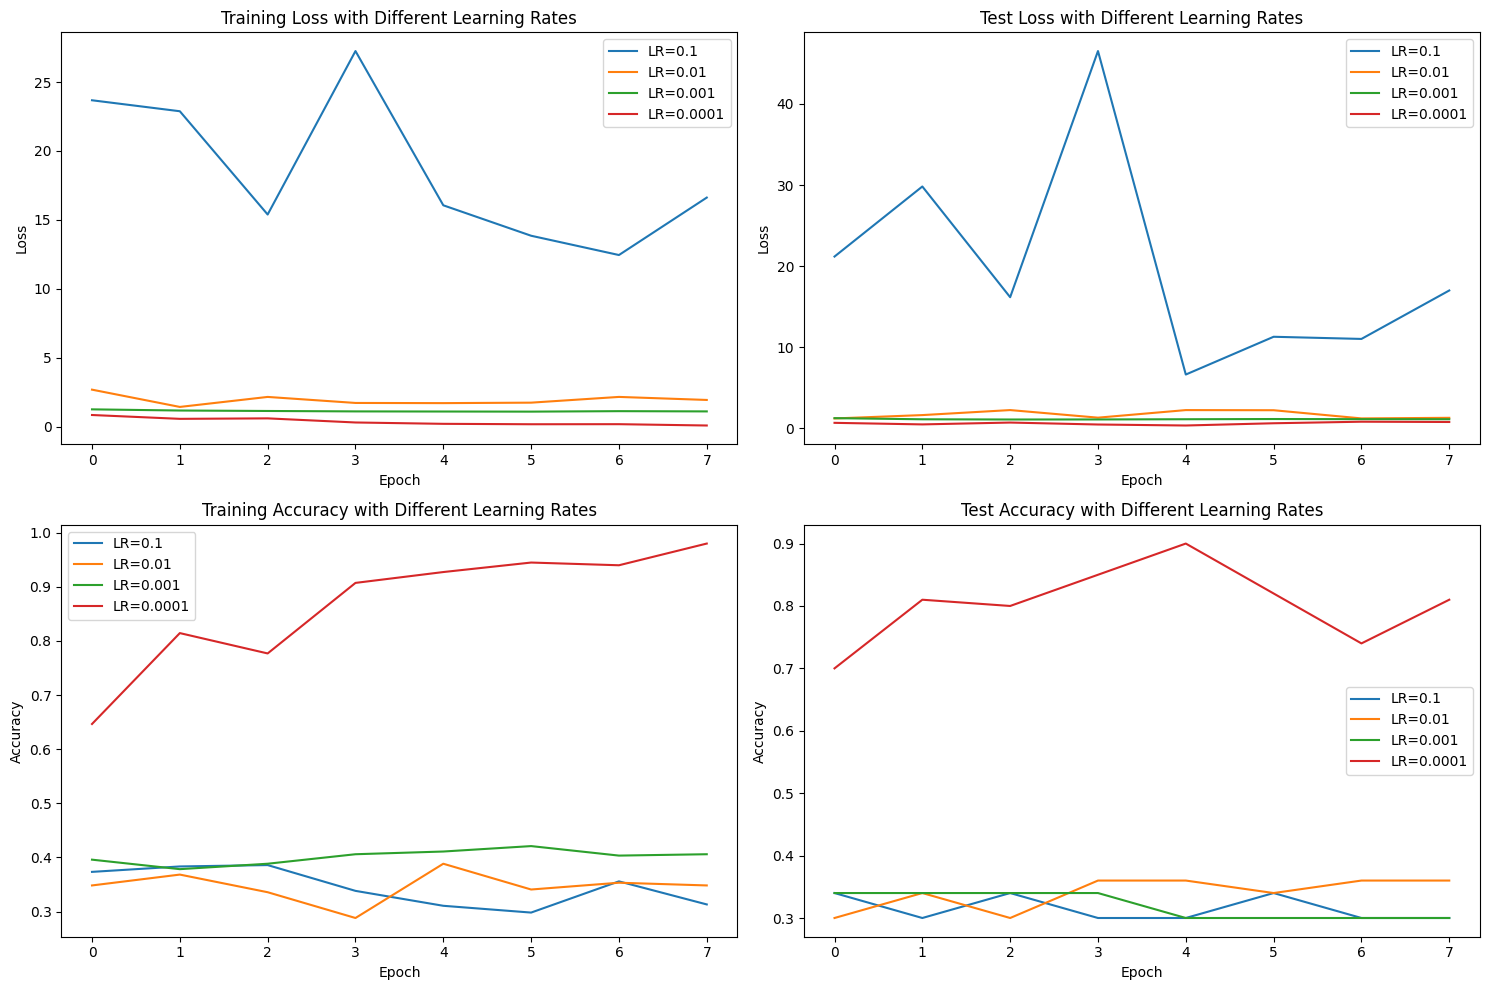

In [19]:
# Define different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = RobertaForSequenceClassification.from_pretrained(model_name).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, optimizer, criterion, num_epochs, unfreeze_after=2, unfreeze_step=4
    )

    results[lr] = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

# Draw a comparison chart of learning rates
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
for lr in learning_rates:
    plt.plot(results[lr]['train_losses'], label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Different Learning Rates')
plt.legend()

plt.subplot(2, 2, 2)
for lr in learning_rates:
    plt.plot(results[lr]['test_losses'], label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss with Different Learning Rates')
plt.legend()

# Accuracy comparison
plt.subplot(2, 2, 3)
for lr in learning_rates:
    plt.plot(results[lr]['train_accuracies'], label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy with Different Learning Rates')
plt.legend()

plt.subplot(2, 2, 4)
for lr in learning_rates:
    plt.plot(results[lr]['test_accuracies'], label=f'LR={lr}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy with Different Learning Rates')
plt.legend()

plt.tight_layout()
plt.show()

                                                 Text  True Label  \
0    'there are people and then there are pencils'...           1   
1                                          Soooo high           1   
2   Screw the reviews, I thought Wolverine was awe...           0   
3                                          Hell Yeah!           1   
4                      Always have wanted to go to Oz           1   
..                                                ...         ...   
95  I`m not sleeping at all until  accepts my appo...           2   
96   I make that same face when I get home and you...           1   
97        I will never fall in love until I found you           0   
98    ohh my tooth is hurts ohh  im sad it very hurts           2   
99                             K will check it out...           1   

    Predicted Label  Correct  
0                 1     True  
1                 1     True  
2                 2    False  
3                 1     True  
4               

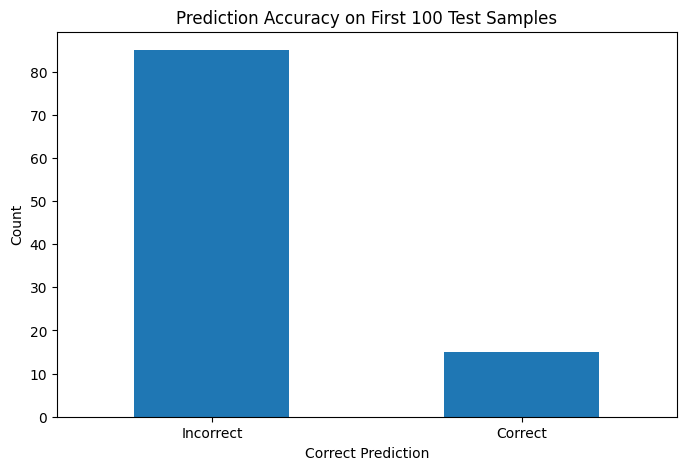

In [24]:
# Obtain the prediction results of the first 100 samples in the test set
model.eval()
predictions = []
true_labels = []
text_samples = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i * batch_size >= 100:
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, 1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        text_samples.extend(test_texts[i*batch_size : (i+1)*batch_size])

# Only take the first 100
predictions = predictions[:100]
true_labels = true_labels[:100]
text_samples = text_samples[:100]

# Create result table
results_df = pd.DataFrame({
    'Text': text_samples,
    'True Label': true_labels,
    'Predicted Label': predictions,
    'Correct': [true == pred for true, pred in zip(true_labels, predictions)]
})
# Obtain the top 100 predicted results
first_100 = results_df.head(100)

# Save as CSV
first_100.to_csv('sample_predictions.csv',
                index=False,
                encoding='utf-8-sig')


# Display the top 100 results
print(results_df.head(100))

# Visualize correct/incorrect distribution
plt.figure(figsize=(8, 5))
results_df['Correct'].value_counts().plot(kind='bar')
plt.title('Prediction Accuracy on First 100 Test Samples')
plt.xlabel('Correct Prediction')
plt.ylabel('Count')
plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
plt.show()

In [25]:
from google.colab import files
files.download("sample_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Set up device
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
print(fold_results)

[0.8125, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

# Evaluation model
evaluate_model(model, test_loader)

Test Accuracy: 0.8400
Test Precision: 0.8574
Test Recall: 0.8419
Test F1 Score: 0.8406


In [ ]:
# Save a model
torch.save(model.state_dict(), 'twi_sentiment_analysis-freeze-cv.pth')

# Loading model
model.load_state_dict(torch.load('twi_sentiment_analysis-freeze-cv.pth'))
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         